*Goal.** Compare two regimes when transferring across seasons:
- **Frozen-model:** Fit on source season(s), score the target season **without** refit.
- **Same-configuration retraining:** Refit on source+target season using the **same hyper-params**.

**Protocol**
1. Define `(train_seasons, test_season)` pairs: e.g. (2021→2023), (2022→2023), (2021+2022→2023).
2. Build OOF **prior** on the training side; score the test season to obtain prior on target.
3. **Frozen-model:** apply trained Stage-2 to the target (no target labels used).
4. **Same-configuration retraining:** refit Stage-2 on (train + target) using identical settings.
5. Compare ROC-AUC/AP/Brier and reliability; summarise overlap of CIs.

In [1]:
# Import and Global Configuration
import json, joblib, numpy as np, pandas as pd
from pathlib import Path
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
from sklearn.metrics import roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier

OUTPUT_DIR = Path("frozen_generalization"); OUTPUT_DIR.mkdir(exist_ok=True)

#  Consistent with the columns used in the 2023 training sessionConsistent with the columns used in the 2023 training session
NUM_COLS_BASE = ["PERIOD","sec_left_period","sec_left_game","bp_last20events",
                 "score_margin","prev_ev1","prev_ev2","prev_ev3"]
CAT_COLS_BASE = ["PLAYER1_TEAM_ID","score_bin","time_bin"]
X_COLS = NUM_COLS_BASE + CAT_COLS_BASE


STACKED_PATH = "stacked_rf_2023_final.joblib"   
STAGE1_PATH  = "stage1_LGBM_full_2023.joblib"  


In [2]:
#Constant
TURNOVER = 5
BADPASS  = 1

def score2num(x):
    if pd.isna(x): return np.nan
    x = str(x).strip().replace("'", "")
    return 0.0 if x.upper()=="TIE" else pd.to_numeric(x, errors="coerce")

def clock2sec(t):
    if pd.isna(t): return np.nan
    try:
        m, s = map(int, str(t).strip().split(":"))
        return m*60 + s
    except:
        return np.nan

def make_features_for_season(df_raw: pd.DataFrame):
    # 1) First, filter down to the "TURNOVER" rowFirst, filter down to the "TURNOVER" row
    df = df_raw[df_raw["EVENTMSGTYPE"] == TURNOVER].copy()

    # 2) Objective: Bad Pass
    if "target" not in df.columns:
        df["target"] = (df["EVENTMSGACTIONTYPE"] == BADPASS).astype(int)

    # Feature logic
    df["score_margin"]    = df["SCOREMARGIN"].apply(score2num)
    df["sec_left_period"] = df["PCTIMESTRING"].apply(clock2sec)
    df["sec_left_game"]   = df["sec_left_period"] + np.where(df["PERIOD"]<=4,(4-df["PERIOD"])*720,0)

    for k in (1,2,3):
        df[f"prev_ev{k}"] = (df.groupby("GAME_ID")["EVENTMSGTYPE"]
                               .shift(k).fillna(0).astype(int))   
    df["score_bin"] = pd.cut(df["score_margin"], [-40,-15,-5,5,15,40],
                             labels=["<-15","-15~-5","-5~5","5~15",">15"])
    df["time_bin"]  = pd.cut(df["sec_left_period"], [0,60,180,360,720],
                             labels=["0-1min","1-3","3-6","6-12"])

    df = df.sort_values(["GAME_ID","PERIOD","sec_left_period"], ascending=[True,True,False])

    df["bp_last20events"] = (
        df.groupby("GAME_ID")["target"]
          .rolling(window=20, min_periods=1).sum()
          .reset_index(level=0, drop=True)
    )

    X = df[[
        "PERIOD","sec_left_period","sec_left_game","bp_last20events",
        "score_margin","prev_ev1","prev_ev2","prev_ev3",
        "PLAYER1_TEAM_ID","score_bin","time_bin"
    ]].copy()

    for c in ["PLAYER1_TEAM_ID","score_bin","time_bin"]:
        X[c] = X[c].astype("category")

    y = df["target"].to_numpy().astype(int)
    groups = df["GAME_ID"].to_numpy()

    print(f"Feature matrix (turnovers only): {X.shape} | Positive rate among turnovers: {y.mean():.3f}")
    return X, y, groups

In [3]:


path_2021 = "nbastats_2021.csv"
path_2022 = "nbastats_2022.csv"
path_2023 = "nbastats_2023.csv"

usecols_needed = ["GAME_ID","PERIOD","PCTIMESTRING","SCOREMARGIN",
                  "EVENTMSGTYPE","EVENTMSGACTIONTYPE","PLAYER1_TEAM_ID","target"]

def load_csv_minimal(path):
    
    df = pd.read_csv(path, low_memory=False)
    return df

df_2021 = load_csv_minimal(path_2021)
df_2022 = load_csv_minimal(path_2022)
df_2023 = load_csv_minimal(path_2023)

X_2021, y_2021, groups_2021 = make_features_for_season(df_2021)
X_2022, y_2022, groups_2022 = make_features_for_season(df_2022)
X_2023, y_2023, groups_2023 = make_features_for_season(df_2023)


Feature matrix (turnovers only): (33857, 11) | Positive rate among turnovers: 0.363
Feature matrix (turnovers only): (34678, 11) | Positive rate among turnovers: 0.336
Feature matrix (turnovers only): (33467, 11) | Positive rate among turnovers: 0.349


In [4]:

lgbm_full_23 = LGBMClassifier(
    n_estimators=600, learning_rate=0.05,
    num_leaves=63, min_child_samples=20,
    subsample=0.8, colsample_bytree=0.8,
    reg_lambda=1.0, class_weight="balanced",
    random_state=42, n_jobs=-1
)
lgbm_full_23.fit(X_2023[X_COLS], y_2023, categorical_feature=CAT_COLS_BASE)
joblib.dump(lgbm_full_23, STAGE1_PATH)
print("Saved:", STAGE1_PATH)


[LightGBM] [Info] Number of positive: 11692, number of negative: 21775
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 575
[LightGBM] [Info] Number of data points in the train set: 33467, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Saved: stage1_LGBM_full_2023.joblib


In [5]:
# Evaluation tool
def _plot_curves(y, p, prefix: Path):
    fpr, tpr, _ = roc_curve(y, p)
    plt.figure(); plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--'); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC"); plt.tight_layout()
    plt.savefig(prefix.with_suffix(".roc.png"), dpi=180); plt.close()
    prec, rec, _ = precision_recall_curve(y, p)
    plt.figure(); plt.plot(rec, prec); plt.hlines(y.mean(), 0, 1, linestyles="--")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR"); plt.tight_layout()
    plt.savefig(prefix.with_suffix(".pr.png"), dpi=180); plt.close()

def eval_frozen(X, y, season_tag: str):
    stage1  = joblib.load(STAGE1_PATH)
    stacked = joblib.load(STACKED_PATH)
    prior = stage1.predict_proba(X[X_COLS])[:, 1]
    X_stk = X.copy(); X_stk["oof_pred"] = prior
    yhat  = stacked.predict_proba(X_stk)[:, 1]
    auc   = roc_auc_score(y, yhat)
    ap    = average_precision_score(y, yhat)
    brier = brier_score_loss(y, yhat)
    print(f"{season_tag}  AUC={auc:.4f}  AP={ap:.4f}  Brier={brier:.4f}")
    out = OUTPUT_DIR / f"frozen2023_to_{season_tag}"
    np.save(out.with_suffix(".y_true.npy"), y); np.save(out.with_suffix(".y_pred.npy"), yhat); np.save(out.with_suffix(".prior.npy"), prior)
    _plot_curves(y, yhat, out)
    with open(out.with_suffix(".metrics.point.json"), "w", encoding="utf-8") as f:
        json.dump({"AUC":float(auc),"AP":float(ap),"Brier":float(brier)}, f, ensure_ascii=False, indent=2)
    return {"Season": season_tag, "AUC": auc, "AP": ap, "Brier": brier}


In [6]:
# Extend to 2021/2022 and then summarize and export
rows = []
rows.append(eval_frozen(X_2021, y_2021, "2021"))
rows.append(eval_frozen(X_2022, y_2022, "2022"))

df = pd.DataFrame(rows)
print("\n== Summary ==")
print(df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))
df.to_csv(OUTPUT_DIR / "frozen_generalization_metrics.csv", index=False)
df.to_json(OUTPUT_DIR / "frozen_generalization_metrics.json", orient="records", indent=2)



d:\Users\14663\anaconda3\envs\passenv\lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['score_margin']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
d:\Users\14663\anaconda3\envs\passenv\lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['score_bin']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


2021  AUC=0.7029  AP=0.5789  Brier=0.2134


d:\Users\14663\anaconda3\envs\passenv\lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['score_margin']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
d:\Users\14663\anaconda3\envs\passenv\lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['score_bin']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


2022  AUC=0.7087  AP=0.5605  Brier=0.2093

== Summary ==
Season    AUC     AP  Brier
  2021 0.7029 0.5789 0.2134
  2022 0.7087 0.5605 0.2093


In [7]:
import joblib, numpy as np
from sklearn.utils.validation import check_is_fitted
from sklearn.preprocessing import OneHotEncoder

stk = joblib.load("stacked_rf_2023_final.joblib")
prep = stk.named_steps["prep"]
clf  = stk.named_steps["clf"]

# Both the preprocessing and the classifier should be in a fitted state.
check_is_fitted(prep)
check_is_fitted(clf)

# The categories_ of OneHot are fixed and handle_unknown is set to ignore.
def find_onehots(est):
    res=[]
    if isinstance(est, OneHotEncoder): res.append(est)
    if hasattr(est, "named_steps"):
        for s in est.named_steps.values(): res += find_onehots(s)
    if hasattr(est, "transformers_"):
        for _, t, _ in est.transformers_: res += find_onehots(t)
    return res

encs = find_onehots(prep)
print("The number of OneHot values", len(encs))
for i,enc in enumerate(encs):
    print(f"[{i}] handle_unknown={enc.handle_unknown}; n_cats={[len(c) for c in enc.categories_]}")


The number of OneHot values 1
[0] handle_unknown=ignore; n_cats=[30, 4]


In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score
rng = np.random.default_rng(0)
for season, (X,y) in {"2021":(X_2021,y_2021), "2022":(X_2022,y_2022)}.items():
    y_rand = rng.permutation(y)          # Rearrange labels
    # Still using the frozen model for prediction
    from copy import deepcopy
    stage1  = joblib.load("stage1_LGBM_full_2023.joblib")
    stk     = joblib.load("stacked_rf_2023_final.joblib")
    prior   = stage1.predict_proba(X[X_COLS])[:,1]
    X_stk   = X.copy(); X_stk["oof_pred"] = prior
    p       = stk.predict_proba(X_stk)[:,1]
    auc = roc_auc_score(y_rand, p)
    ap  = average_precision_score(y_rand, p)
    print(season, "Random label baseline  AUC≈0.5 ->", round(auc,3), "| AP ≈ Proportion of Positive Examples ->", round(ap,3), "(Proportion of positive examples=", round(y.mean(),3), ")")


d:\Users\14663\anaconda3\envs\passenv\lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['score_margin']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
d:\Users\14663\anaconda3\envs\passenv\lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['score_bin']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


2021 Random label baseline  AUC≈0.5 -> 0.494 | AP ≈ Proportion of Positive Examples -> 0.361 (Proportion of positive examples= 0.363 )
2022 Random label baseline  AUC≈0.5 -> 0.506 | AP ≈ Proportion of Positive Examples -> 0.341 (Proportion of positive examples= 0.336 )


d:\Users\14663\anaconda3\envs\passenv\lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['score_margin']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
d:\Users\14663\anaconda3\envs\passenv\lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['score_bin']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
import numpy as np

def eval_with_shuffled_prior(X, y, seed=0):
    stage1  = joblib.load("stage1_LGBM_full_2023.joblib")
    stk     = joblib.load("stacked_rf_2023_final.joblib")
    prior   = stage1.predict_proba(X[X_COLS])[:,1]
    prior_s = prior.copy()
    rng = np.random.default_rng(seed); rng.shuffle(prior_s)  # Disrupt the a priori

    X_stk   = X.copy(); X_stk["oof_pred"] = prior
    X_stk_s = X.copy(); X_stk_s["oof_pred"] = prior_s

    p  = stk.predict_proba(X_stk)[:,1]
    ps = stk.predict_proba(X_stk_s)[:,1]

    def metr(y, p): 
        return (roc_auc_score(y,p), average_precision_score(y,p), brier_score_loss(y,p))
    return metr(y,p), metr(y,ps)

for season,(X,y) in {"2021":(X_2021,y_2021), "2022":(X_2022,y_2022)}.items():
    m_ok, m_bad = eval_with_shuffled_prior(X,y)
    print(season, "Original:", [round(x,4) for x in m_ok], "  After disrupting oof_pred:", [round(x,4) for x in m_bad])


d:\Users\14663\anaconda3\envs\passenv\lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['score_margin']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
d:\Users\14663\anaconda3\envs\passenv\lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['score_bin']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
d:\Users\14663\anaconda3\envs\passenv\lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['score_margin']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
d:\Users\14663\anaconda3\envs\passenv\lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['score_bin']. At least one non-missing value is needed for imputation 

2021 Original: [0.7029, 0.5789, 0.2134]   After disrupting oof_pred: [0.6493, 0.5348, 0.2306]


d:\Users\14663\anaconda3\envs\passenv\lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['score_margin']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
d:\Users\14663\anaconda3\envs\passenv\lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['score_bin']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
d:\Users\14663\anaconda3\envs\passenv\lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['score_margin']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
d:\Users\14663\anaconda3\envs\passenv\lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['score_bin']. At least one non-missing value is needed for imputation 

2022 Original: [0.7087, 0.5605, 0.2093]   After disrupting oof_pred: [0.6478, 0.5088, 0.2258]


In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import roc_curve, precision_recall_curve, auc, average_precision_score, brier_score_loss, roc_auc_score

OUT = OUTPUT_DIR  
def load_preds(tag):
    y = np.load(OUT / f"frozen2023_to_{tag}.y_true.npy")
    p = np.load(OUT / f"frozen2023_to_{tag}.y_pred.npy")
    return y, p

y21, p21 = load_preds("2021")
y22, p22 = load_preds("2022")

# Combine 2021 + 202
y12 = np.concatenate([y21, y22])
p12 = np.concatenate([p21, p22])


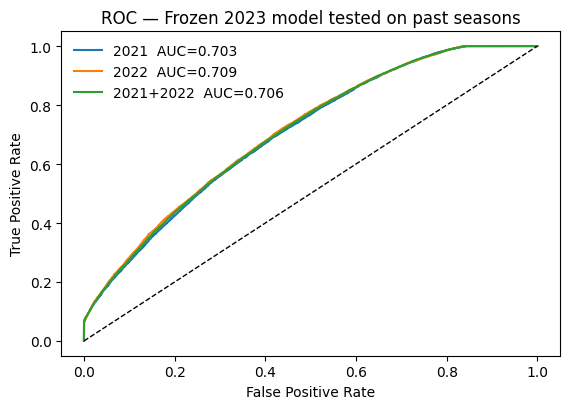

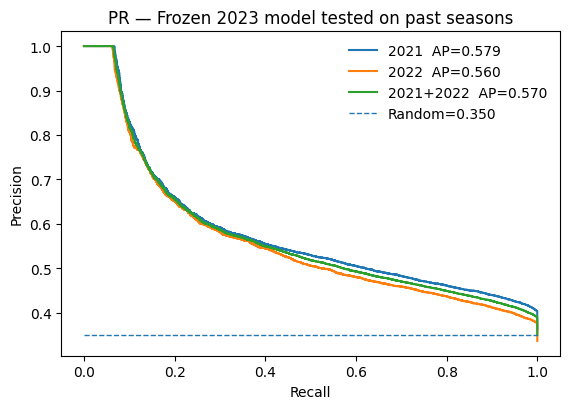

In [ ]:
# ROC superposition
plt.figure(figsize=(5.8, 4.2))
for tag, (y, p) in {"2021": (y21,p21), "2022": (y22,p22), "2021+2022": (y12,p12)}.items():
    fpr, tpr, _ = roc_curve(y, p)
    plt.plot(fpr, tpr, label=f"{tag}  AUC={roc_auc_score(y,p):.3f}")
plt.plot([0,1],[0,1],'k--',lw=1)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC — Frozen 2023 model tested on past seasons")
plt.legend(frameon=False); plt.tight_layout()
plt.savefig(OUT / "frozen_roc_overlay.png", dpi=200)
plt.show()

# PR superposition
plt.figure(figsize=(5.8, 4.2))
for tag, (y, p) in {"2021": (y21,p21), "2022": (y22,p22), "2021+2022": (y12,p12)}.items():
    pr, rc, _ = precision_recall_curve(y, p)
    ap = average_precision_score(y, p)
    plt.plot(rc, pr, label=f"{tag}  AP={ap:.3f}")
# Draw an overall baseline (positive rate)
plt.hlines(y12.mean(), 0, 1, linestyles="--", linewidth=1, label=f"Random={y12.mean():.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("PR — Frozen 2023 model tested on past seasons")
plt.legend(frameon=False); plt.tight_layout()
plt.savefig(OUT / "frozen_pr_overlay.png", dpi=200)
plt.show()


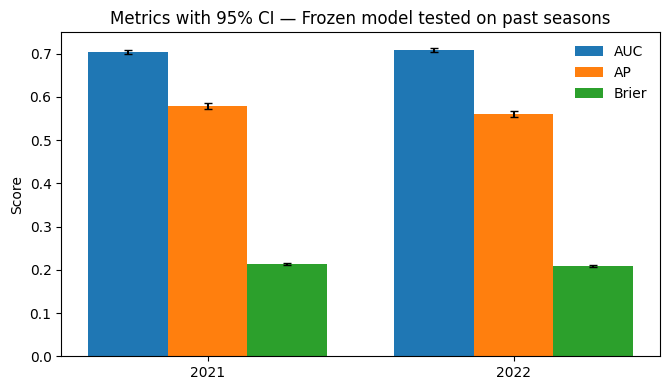

In [ ]:
def grouped_bootstrap_ci(y, p, groups, n_boot=1000, seed=42):
    rng = np.random.default_rng(seed)
    df = pd.DataFrame({"y":y, "p":p, "g":groups})
    games = df["g"].unique()
    aucs, aps, brs = [], [], []
    for _ in range(n_boot):
        samp = rng.choice(games, size=len(games), replace=True)
        b = pd.concat([df[df.g==gid] for gid in samp], axis=0)
        if b.y.nunique() < 2:  
            continue
        aucs.append(roc_auc_score(b.y,b.p))
        aps.append(average_precision_score(b.y,b.p))
        brs.append(brier_score_loss(b.y,b.p))
    q = lambda v: (float(np.mean(v)), float(np.percentile(v,2.5)), float(np.percentile(v,97.5)))
    A, P, B = q(aucs), q(aps), q(brs)
    return {"AUC":A, "AP":P, "Brier":B}

ci21 = grouped_bootstrap_ci(y21, p21, groups_2021)
ci22 = grouped_bootstrap_ci(y22, p22, groups_2022)


labels = ["2021","2022"]
metrics = ["AUC","AP","Brier"]
means = [[ci21[m][0], ci22[m][0]] for m in metrics]
los   = [[ci21[m][1], ci22[m][1]] for m in metrics]
his   = [[ci21[m][2], ci22[m][2]] for m in metrics]

x = np.arange(len(labels)); w = 0.26
plt.figure(figsize=(6.8, 4.0))
for i,m in enumerate(metrics):
    mu = [means[i][0], means[i][1]]
    lo = [mu[0]-los[i][0], mu[1]-los[i][1]]
    hi = [his[i][0]-mu[0], his[i][1]-mu[1]]
    plt.bar(x + (i-1)*w, mu, width=w, yerr=[lo,hi], capsize=3, label=m)
plt.xticks(x, labels); plt.ylabel("Score")
plt.title("Metrics with 95% CI — Frozen model tested on past seasons")
plt.legend(frameon=False); plt.tight_layout()
plt.savefig(OUT / "frozen_metrics_bar_ci.png", dpi=200)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss

# Grouping by competition method (CI)
def grouped_bootstrap_ci(y, p, groups, n_boot=1000, seed=42):
    rng = np.random.default_rng(seed)
    df = pd.DataFrame({"y": y, "p": p, "g": groups})
    games = df["g"].unique()
    aucs, aps, brs = [], [], []
    for _ in range(n_boot):
        samp = rng.choice(games, size=len(games), replace=True)
        b = pd.concat([df[df["g"] == gid] for gid in samp], ignore_index=True)
        if b["y"].nunique() < 2:  
            continue
        aucs.append(roc_auc_score(b.y, b.p))
        aps.append(average_precision_score(b.y, b.p))
        brs.append(brier_score_loss(b.y, b.p))
    def mean_ci(v):
        v = np.asarray(v, float)
        return float(np.mean(v)), float(np.percentile(v, 2.5)), float(np.percentile(v, 97.5))
    return {"AUC": mean_ci(aucs), "AP": mean_ci(aps), "Brier": mean_ci(brs)}

# Calculate the CI for the two seasons 
ci21 = grouped_bootstrap_ci(y21, p21, groups_2021, n_boot=1000, seed=42)
ci22 = grouped_bootstrap_ci(y22, p22, groups_2022, n_boot=1000, seed=42)


def print_ci_table(ci_list, labels, k=3):
    def fmt(t): mu, lo, hi = t; return f"{mu:.{k}f} [{lo:.{k}f}, {hi:.{k}f}]"
    header = f"{'Training Source':<16}{'AUC (95% CI)':>18}{'AP (95% CI)':>18}{'Brier (95% CI)':>20}"
    print(header)
    print("-" * len(header))
    for lab, ci in zip(labels, ci_list):
        print(f"{lab:<16}{fmt(ci['AUC']):>18}{fmt(ci['AP']):>18}{fmt(ci['Brier']):>20}")

print_ci_table([ci21, ci22], ['2021', '2022'])


Training Source       AUC (95% CI)       AP (95% CI)      Brier (95% CI)
------------------------------------------------------------------------
2021            0.703 [0.698, 0.708]0.579 [0.572, 0.586]0.213 [0.212, 0.215]
2022            0.709 [0.704, 0.713]0.561 [0.553, 0.568]0.209 [0.208, 0.211]


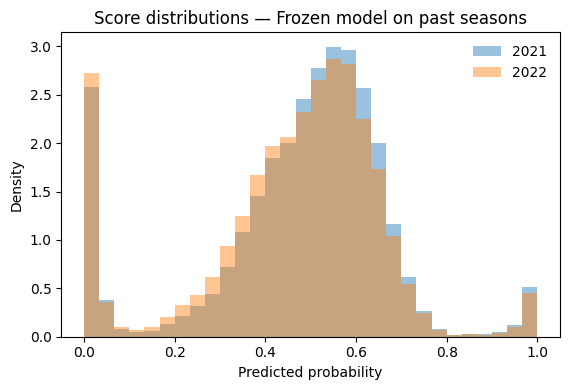

In [16]:
plt.figure(figsize=(5.8, 4.0))
bins = np.linspace(0, 1, 31)
plt.hist(p21, bins=bins, density=True, alpha=0.45, label="2021")
plt.hist(p22, bins=bins, density=True, alpha=0.45, label="2022")
plt.xlabel("Predicted probability"); plt.ylabel("Density")
plt.title("Score distributions — Frozen model on past seasons")
plt.legend(frameon=False); plt.tight_layout()
plt.savefig(OUT / "frozen_score_hist.png", dpi=200)
plt.show()


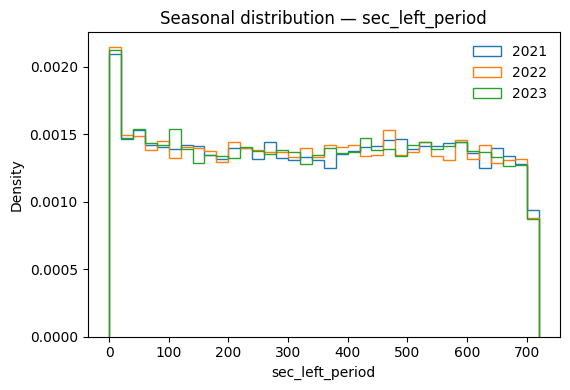

In [19]:
plt.figure(figsize=(5.8, 4.0))
bins = np.arange(0, 721, 20)
plt.hist(X_2021["sec_left_period"], bins=bins, density=True, histtype="step", label="2021")
plt.hist(X_2022["sec_left_period"], bins=bins, density=True, histtype="step", label="2022")
plt.hist(X_2023["sec_left_period"], bins=bins, density=True, histtype="step", label="2023")
plt.xlabel("sec_left_period"); plt.ylabel("Density")
plt.title("Seasonal distribution — sec_left_period")
plt.legend(frameon=False); plt.tight_layout()
plt.savefig(OUT / "frozen_feature_dist_sec_left_period.png", dpi=200)
plt.show()
